In [1]:
import numpy as np
import pandas as pd
import Perceptron.perceptron as pn
from Perceptron.data_gen import Universe, separable_regression
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, zero_one_loss
from sklearn import datasets
import matplotlib.pyplot as plt
from collections import defaultdict
import pickle
import math
from tqdm import tqdm
import argparse

# Data Corruption Experiment

In [2]:
from typing import List, Tuple
import random

def corrupt_data(
    universe_len:  int,
    buckets:       int,
    test_split:    float=None,
    )->Tuple[List[int], List[int]]:
    """Create uniform corruption buckets.
    
    The function shall pick random indices within the entire 
    data universe. The number of indices will be the same as
    abscribed in the call of the function. Then, the indices
    will be split into buckets of several sizes. These shall
    be returned.
    
    Testing will not be split into buckets if specified.
    """
    
    assert 0 < test_split < 1 or test_split == None, "Invalid test split value"
    
    # Create shuffled indices
    indices  = np.random.choice(universe_len, universe_len, replace=False)
    
    training = testing = None
    
    if test_split is not None:
        split      = int(universe_len - (test_split * universe_len))
        training   = indices[:split]
        testing    = indices[split:]
    else:
        training = indices
    
    bucket_len = int(len(training) / buckets)
    # Split into buckets
    train_buckets = [ training[ bucket_len*i:bucket_len*(i+1) ] for i in range(buckets)]
    
    return np.array(train_buckets), testing

## Custom Data Generation

In [ ]:
X, y = separable_regression(
    weights  =np.array([[605], [-358], [-124], [73]]),
    dim_dist = ((-1, 1), (-1, 1), (-1, 1), (1, 1)), 
    dim_step =(37, 37, 37, 1))

In [36]:
X, y = separable_regression(
    weights  =np.array([[605], [-358], [-124], [73]]),
    dim_dist = ((-1, 1), (-1, 1), (-1, 1), (1, 1)), 
    dim_step =(21, 21, 21, 1))

In [33]:
X, y = separable_regression(
    weights  =np.array([[605], [-358], [73]]),
    dim_dist = ((-1, 1), (-1, 1), (1, 1)), 
    dim_step =(100, 100, 1))

In [3]:
X, y = separable_regression(
    weights  =np.array([[605], [-358], [73]]),
    dim_dist = ((-1, 1), (-1, 1), (1, 1)), 
    dim_step =(50, 50, 1))

In [4]:
print(f'1: {len(y[y==-1])} vs -1: {len(y[y==1])} from {len(y)}')

1: 1103 vs -1: 1397 from 2500


In [20]:
def experiment(
    X,
    y,
    metric,
    test_split:   float,
    buckets:       int,
    n_runs:        int,
    verbose:       bool,
    n_buckets:     int, 
    max_iter:      int,
    eta:           float,
    ):
    
    assert len(X) == len(y), 'Shapes of input data and labels does not match!'
    
    # Bukcetize data
    training_size = int(len(X)*0.8)
    testing_size  = len(X) - training_size 
    train, test = corrupt_data(universe_len=len(X), 
                               buckets=buckets,
                               test_split=test_split)
    
    # Create dictionary to store results
    exp_data = defaultdict(lambda : [])
    
    # Experiment
    for run in range(n_runs):
        if verbose > 0:
            print(f"Start of run {run}.")
        
        
        # begin bining
        empirical_score = []
        for bins in range(1, n_buckets):

            # Create model; No innate bias included!
            model = pn.PocketPerceptron(
                input=X.shape[-1], 
                eta=eta, 
                max_iter=max_iter
            ) 
            
            # Grab training data
            m      = np.concatenate(X[train[:bins]])
            labels = np.concatenate(y[train[:bins]])
            
            if verbose > 1:
                print(f"Training with {bins} buckets -- {len(m)}")
            
            # Train model
            model.train(m, labels)
            
            # Store risk data
            if testing_size: 
                pred = model.solve(X[test])
                exp_data[bins].append(metric(y[test], pred))
            
            else: # No empirical testing. Take error over all data.
                pred = model.solve(X)
                exp_data[bins].append(metric(y, pred))

            #true_score.append(accuracy_score(y, model.solve(X)))
        #import pdb; pdb.set_trace()
    return dict(exp_data)

In [ ]:
def make_parser():
    parser = argparse.ArgumentParser(description='Corruption Experiment', fromfile_prefix_chars='@')
    
    parser.add_argument('--test_size',     type=float, default=0.2, help='Test set portion')
    parser.add_argument('--buckets',       type=int, default=20, help='Number of buckets to split data into')
    parser.add_argument('--epochs',        type=int, default=10, help='Number of times experiment is run')
    parser.add_argument('--verbose', '-v',  action='count', default=0, help='Verbosity')
    parser.add_argument('--max_buckets',   type=int, default=19, help='Maximum number of buckets used')
    parser.add_argument('--max_iter',      type=int, default=100, help='Maximum number of iterations for convergance') #TODO Continue adding parameters!
    parser.add_argument('--learning_rate', type=float, default=1, help='Perceptron learning rate (eta)')
    parser.add_argument('--store_at',      type=str, default='pickles/', help='Directory where to save results')
    parser.add_argument('--label',         type=str, default='experiment', help='Label to add to pickle file')


In [25]:
def pickle_data(
    root_dir, 
    results,
    args):
    
    # Make sure it is a directory!
    if root_dir[-1] != '/':
        root_dir += '/'
    
    # Create pickle structure
    pkl = {
        'results': dict(results),
        'args':    args,
    }
    
    
    # Create file name

    file_name = f"{args['label']}_test_size_{args['test_size']}.pkl"
    
    with open(f"{root_dir}{file_name}", 'wb') as pkl_file:
        pickle.dump(pkl, pkl_file)

In [27]:
def main(args):
    
    # Generate dataset
    # X, y
    
    # Select metric
    metric = zero_one_loss
    
    results = experiment(
        X          = X, 
        y          = y, 
        metric     = metric, 
        test_split = args['test_size'], 
        buckets    = args['buckets'], 
        n_runs     = args['epochs'], 
        verbose    = args['verbose'], 
        n_buckets  = args['max_buckets'], 
        max_iter   = args['max_iter'], 
        eta        = args['learning_rate'])
    
    if args['store_at'] is not None:
        #pickle data!
        pickle_data(root_dir=args['store_at'], results=results, args=args)





In [40]:
# Third element in tuple is for bias
#u = Universe(((-10, 10), (-10, 10), (1, 1)), (1000, 1000, 1))
#data = u.gen()

# Parameters for dataset creation
training_size = int(len(X)*0.8)
testing_size  = len(X) - training_size 
n_buckets     = 50

# Pocket Algorithm hyper-parameters
eta           = 0.1
metric        = zero_one_loss
pickles       = True
exp_name      = 'perceptron_synthetic'
verbose       = 2

n_runs        = 250
max_iter      = 5000

# Obtain indices
train, test   = corrupt_data(
    universe_len=len(y),
    training_size=training_size,
    testing_size=testing_size,
    buckets=n_buckets)

# Perform corruption

exp_data = defaultdict(lambda : [])
# Experiment
for run in range(n_runs):
    if verbose > 0:
        print(f"Start of run {run}.")
    # shuffle bin indices
    bucket_index = random.sample(range(n_buckets), n_buckets)
    # begin bining
    empirical_score = []
    #true_score      = []
    for bins in range(1, n_buckets):
        
        # Create model; No innate bias included!
        model = pn.PocketPerceptron(
            input=X.shape[-1], 
            eta=eta, 
            max_iter=max_iter
        ) 
        # Grab training data
        m = np.concatenate(X[train[bucket_index[:bins]]])
        if verbose > 1:
            print(f"Training with {bins} buckets -- {len(m)}")
        # Train model
        model.train(m, np.concatenate(y[train[bucket_index[:bins]]]))
        # Store empirical and "true"
        if testing_size:
            pred = model.solve(X[test])
            exp_data[bins].append(metric(y[test], pred))
        else: # No empirical testing. Just true
            pred = model.solve(X)
            exp_data[bins].append(metric(y, pred))
        
        #true_score.append(accuracy_score(y, model.solve(X)))
    #import pdb; pdb.set_trace()
        
if pickles:
    
    pkl = {}
    pkl[exp_name] = dict(exp_data)
    # Create file name
    fname = f'pickles/{exp_name}_buckets_{n_buckets}_runs_{n_runs}_metric_{metric.__qualname__}_nsamples_{X.shape[0]}_attribs_{X.shape[-1]}.pkl'
    with open(fname, 'wb') as pkl_file:
        pickle.dump(pkl, pkl_file)

Start of run 0.
Training with 1 buckets -- 148
Training with 2 buckets -- 296
Training with 3 buckets -- 444
Training with 4 buckets -- 592
Training with 5 buckets -- 740
Training with 6 buckets -- 888
Training with 7 buckets -- 1036
Training with 8 buckets -- 1184
Training with 9 buckets -- 1332
Training with 10 buckets -- 1480
Training with 11 buckets -- 1628
Training with 12 buckets -- 1776
Training with 13 buckets -- 1924
Training with 14 buckets -- 2072
Training with 15 buckets -- 2220
Training with 16 buckets -- 2368
Training with 17 buckets -- 2516
Training with 18 buckets -- 2664
Training with 19 buckets -- 2812
Training with 20 buckets -- 2960
Training with 21 buckets -- 3108
Training with 22 buckets -- 3256
Training with 23 buckets -- 3404
Training with 24 buckets -- 3552
Training with 25 buckets -- 3700
Training with 26 buckets -- 3848
Training with 27 buckets -- 3996
Training with 28 buckets -- 4144
Training with 29 buckets -- 4292
Training with 30 buckets -- 4440
Training 

KeyboardInterrupt: 

In [19]:
pkl = {}
pkl[exp_name] = dict(exp_data)
# Create file name
fname = f'pickles/{exp_name}_buckets_{n_buckets}_runs_{n_runs}_metric_{metric.__qualname__}_nsamples_{X.shape[0]}_attribs_{X.shape[-1]}.pkl'
with open(fname, 'wb') as pkl_file:
    pickle.dump(pkl, pkl_file)

In [127]:
exp_3d = exp_data

# PAC Bounds

In [22]:
def sample_complexity(vc_dim, epsilon, delta):
    return math.ceil(
        (4/epsilon) * (vc_dim*math.log(12/epsilon) + math.log(2/delta))
    )

# Bucket sizes
bucket_sizes = [150 * n for n in range(1, 51)]

vc_dim = X.shape[-1] + 1
# Create Complexity dictoniary.
delta_dict = {}
for delta in [0.01]:
    complexity_epsilon_dict = {sample_complexity(vc_dim, epsilon, delta): epsilon for epsilon in np.linspace(0.0001, 0.5, 1000000)}
    delta_dict[f'Conficence: {1 - delta}'] = [complexity_epsilon_dict[m] for m in bucket_sizes]

if delta_dict[]


In [30]:
delta_dict['Conficence: 0.9'][12]

0.05098087268087268

## Results

KeyError: 'Error Upper Bound: 0.9'

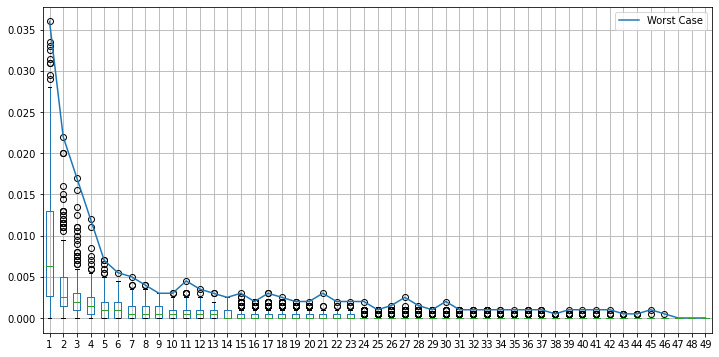

In [23]:
_, ax = plt.subplots()


pd.DataFrame(exp_data).boxplot(figsize=(15, 6), ax=ax)
pd.DataFrame(exp_data).max().plot(figsize=(12, 6), grid=True, ax=ax, legend=True, label='Worst Case')
pd.DataFrame(delta_dict).reset_index().rename(columns={f'Confidence: {1 - delta}': f'Error Upper Bound: {1 - delta}'}).plot.scatter(x='index', y=f'Error Upper Bound: {1 - delta}', ax=ax, grid=True, figsize=(12, 6), color='Orange', legend=False)
pd.DataFrame(delta_dict).rename(columns={f'Confidence: {1 - delta}': f'Error Upper Bound: {1 - delta}'}).plot(ax=ax, figsize=(12, 6), grid=True, legend=True, color='Orange')



ax.set_xlabel("Buckets Used")
ax.set_ylabel("Zero/One score")
ax.set_title(f"Testing Score Distribution per Buckets Used -- Synthetic Dataset")
ax.set_yticks(np.linspace(0, 0.1, 51))
ax.set_ylim(0, 0.03)
ax.set_xlim(0, 50)
plt.savefig('TestingVBucketsSynthetic.png')

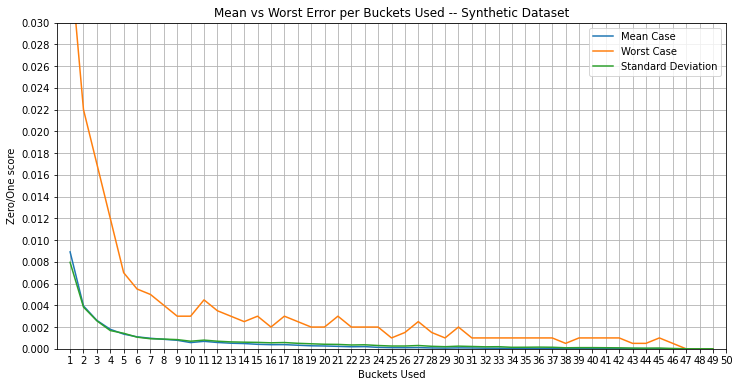

In [14]:
_, ax = plt.subplots()

pd.DataFrame(exp_data).mean().plot(figsize=(12, 6), grid=True, ax=ax, legend=True, label='Mean Case')
pd.DataFrame(exp_data).max().plot(figsize=(12, 6), grid=True, ax=ax, legend=True, label='Worst Case')
pd.DataFrame(exp_data).std().plot(figsize=(12, 6), grid=True, ax=ax, legend=True, label='Standard Deviation')


ax.set_xlabel("Buckets Used")
ax.set_ylabel("Zero/One score")
ax.set_title(f"Mean vs Worst Error per Buckets Used -- Synthetic Dataset")
ax.set_yticks(np.linspace(0, 0.03, 16))
ax.set_xticks(np.arange(1, n_buckets + 1, 1))
ax.set_ylim(0, 0.03)
ax.set_xlim(0, 50)
plt.savefig('MeanVWorstVSTDSynthetic.png')

<AxesSubplot:>

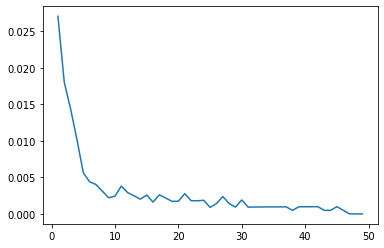

In [15]:
(pd.DataFrame(exp_data).max() - pd.DataFrame(exp_data).mean()).plot()


<AxesSubplot:>

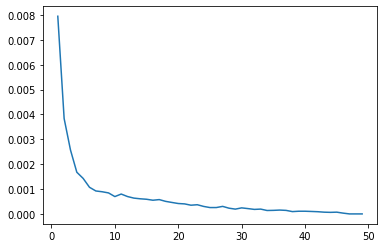

In [16]:
pd.DataFrame(exp_data).std().plot()

<AxesSubplot:>

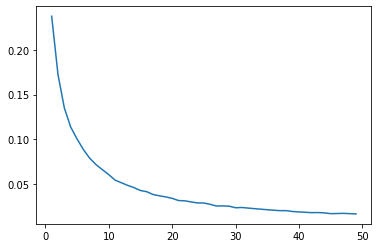

In [17]:
( pd.DataFrame(delta_dict).squeeze()[1:] - pd.DataFrame(exp_data).max()).plot()

KeyError: 'Confidence: 0.99'

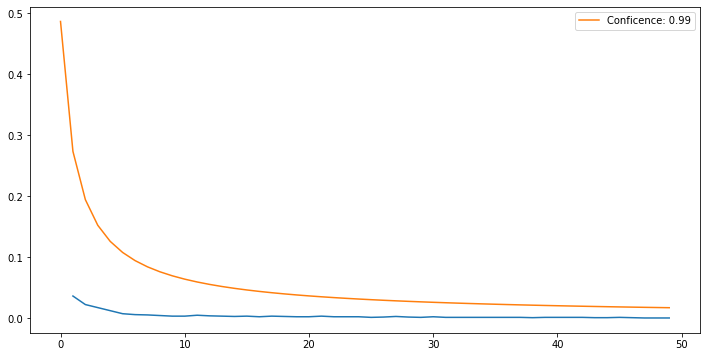

In [18]:
_, ax = plt.subplots()

pd.DataFrame(exp_data).max().plot(figsize=(12, 6), grid=True, ax=ax)
pd.DataFrame(delta_dict).plot(ax=ax)
pd.DataFrame(delta_dict).reset_index().plot.scatter(x='index', y=f'Confidence: {1 - delta}', ax=ax, grid=True, figsize=(12, 6))
ax.set_xlabel("Buckets Used")
ax.set_ylabel("Zero/One score")
ax.set_title(f"Worst Testing Score per Buckets Used -- Synthetic Dataset")
ax.set_xticks(np.arange(1, n_buckets + 1, 1))
ax.set_yticks(np.linspace(0, 0.1, 21))
ax.set_ylim(0, 0.05)
ax.set_xlim(0, 50)
plt.savefig('WorstVBucketsSynthetic.png')

# Breast Cancer Winsconsin Dataset

In [12]:
wbc = datasets.load_breast_cancer()
X = wbc['data'][:, :10]
y = wbc['target']
# Prepare for Perceptron predicitons
y[y==0] = -1

In [18]:
# Third element in tuple is for bias
#u = Universe(((-10, 10), (-10, 10), (1, 1)), (1000, 1000, 1))
#data = u.gen()

# Parameters for dataset creation
training_size = int(len(X)*0.85)
testing_size  = len(X) - training_size 
n_buckets     = 10
# Pocket Algorithm hyper-parameters
max_iter      = 500
eta           = 1
metric        = zero_one_loss
pickles       = True
exp_name      = 'perceptron_cancer'

# Obtain indices
train, test   = corrupt_data(
    universe_len=len(y),
    training_size=training_size,
    testing_size=testing_size,
    buckets=n_buckets)

# Perform corruption
n_runs = 25
exp_data = defaultdict(lambda : [])
# Experiment
for run in range(n_runs):
    print(f"Start of run {run}.")
    #import pdb; pdb.set_trace()
    # shuffle bin indices
    bucket_index = random.sample(range(n_buckets), n_buckets)
    # begin bining
    empirical_score = []
    #true_score      = []
    for bins in range(1, n_buckets):
        
        # Create model; No innate bias included!
        model = pn.PocketPerceptron(
            input=X.shape[-1], 
            eta=eta, 
            max_iter=max_iter
        ) 
        # Grab training data
        m = np.concatenate(X[train[bucket_index[:bins]]])
        print(f"Training with {bins} buckets -- {len(m)}")
        # Train model
        model.train(m, np.concatenate(y[train[bucket_index[:bins]]]))
        # Store empirical and "true"
        if testing_size:
            pred = model.solve(X[test])
            exp_data[bins].append(metric(y[test], pred))
        else: # No empirical testing. Just true
            pred = model.solve(X)
            exp_data[bins].append(metric(y, pred))
        
        #true_score.append(accuracy_score(y, model.solve(X)))
    #import pdb; pdb.set_trace()
        
if pickles:
    pkl = {}
    pkl[exp_name] = exp_data
    # Create file name
    fname = f'pickles/{exp_name}_{n_buckets}_{n_runs}_{metric.__qualname__}.pkl'
    with open(fname, 'wb') as pkl_file:
        pickle.dump(pkl, pkl_file)

Start of run 0.
Training with 1 buckets -- 48
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 2 buckets -- 96
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 3 buckets -- 144
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 4 buckets -- 192
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 5 buckets -- 240
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 6 buckets -- 288
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 7 buckets -- 336
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 8 buckets -- 384
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 9 buckets -- 432
Maximum iterations reached: No convergence. Ignore if data is non-separable
Start of run 1.
Trainin

Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 6 buckets -- 288
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 7 buckets -- 336
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 8 buckets -- 384
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 9 buckets -- 432
Maximum iterations reached: No convergence. Ignore if data is non-separable
Start of run 9.
Training with 1 buckets -- 48
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 2 buckets -- 96
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 3 buckets -- 144
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 4 buckets -- 192
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 5 buckets -- 240
Maximum iterations reac

Maximum iterations reached: No convergence. Ignore if data is non-separable
Start of run 17.
Training with 1 buckets -- 48
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 2 buckets -- 96
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 3 buckets -- 144
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 4 buckets -- 192
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 5 buckets -- 240
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 6 buckets -- 288
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 7 buckets -- 336
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 8 buckets -- 384
Maximum iterations reached: No convergence. Ignore if data is non-separable
Training with 9 buckets -- 432
Maximum iterations rea

NameError: name 'pickle' is not defined

## Results

Text(0.5, 1.0, 'Testing Score Distribution per Buckets Used -- Winsconsin Dataset')

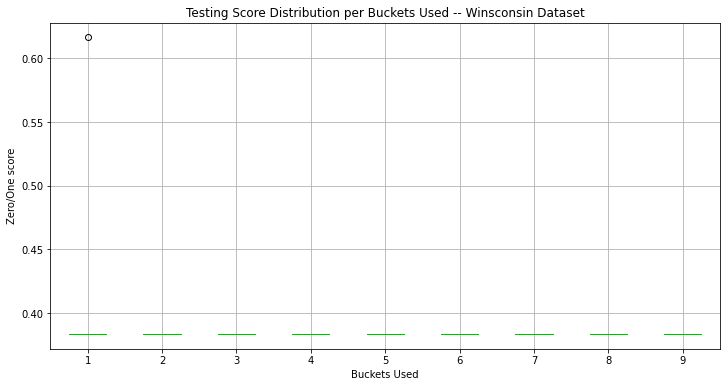

In [20]:
pd.DataFrame(exp_data).boxplot(figsize=(12, 6))
plt.xlabel("Buckets Used")
plt.ylabel("Zero/One score")
plt.title(f"Testing Score Distribution per Buckets Used -- Winsconsin Dataset")

([<matplotlib.axis.YTick at 0x7f9bd1e21ca0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

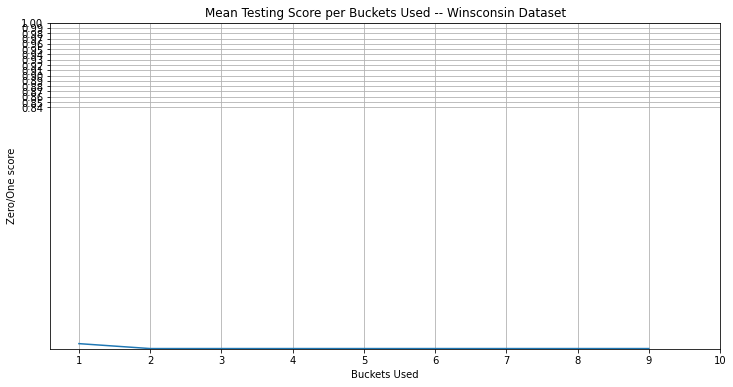

In [21]:
pd.DataFrame(exp_data).mean().plot(figsize=(12, 6), grid=True)
plt.xlabel("Buckets Used")
plt.ylabel("Zero/One score")
plt.title(f"Mean Testing Score per Buckets Used -- Winsconsin Dataset")
plt.xticks(np.arange(1, n_buckets + 1, 1))
plt.yticks(np.linspace(0.84, 1.0, 17))

([<matplotlib.axis.YTick at 0x7f9bd026a700>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

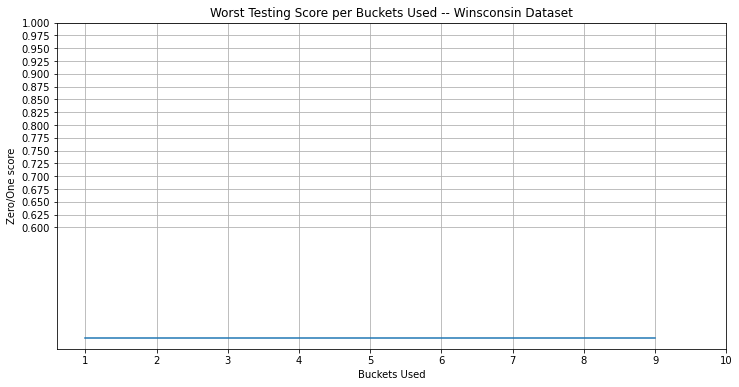

In [22]:
pd.DataFrame(exp_data).min().plot(figsize=(12, 6), grid=True)
plt.xlabel("Buckets Used")
plt.ylabel("Zero/One score")
plt.title(f"Worst Testing Score per Buckets Used -- Winsconsin Dataset")
plt.xticks(np.arange(1, n_buckets + 1, 1))
plt.yticks(np.linspace(0.6, 1.0, 17))

## Visualizations

In [133]:
with open('results/presentation_rand_hard_test_size_0.2.pkl', 'rb') as pkl:
    data = pickle.load(pkl)

In [134]:
np.array(list(data['results'].keys()))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48])

In [135]:
(np.array(list(data['results'].keys())).astype(int)*(9400 // 50))[5]

1128

In [136]:
data

{'results': {1: [0.2833333333333333,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.2833333333333333,
   0.4,
   0.4,
   0.2833333333333333,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.4,
   0.06666666666666665,
   0.06666666666666665,
   0.2666666666666667,
   0.2833333333333333,
   0.4,
   0.06666666666666665,
   0.06666666666666665,
   0.2833333333333333,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.41666666666666663,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.2833333333333333,
   0.2833333333333333,
   0.06666666666666665,
   0.2833333333333333,
   0.2833333333333333,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.06666666666666665,
   0.41666666666666663,
   0.4,
   0.066666666666666

(0.0, 50.0)

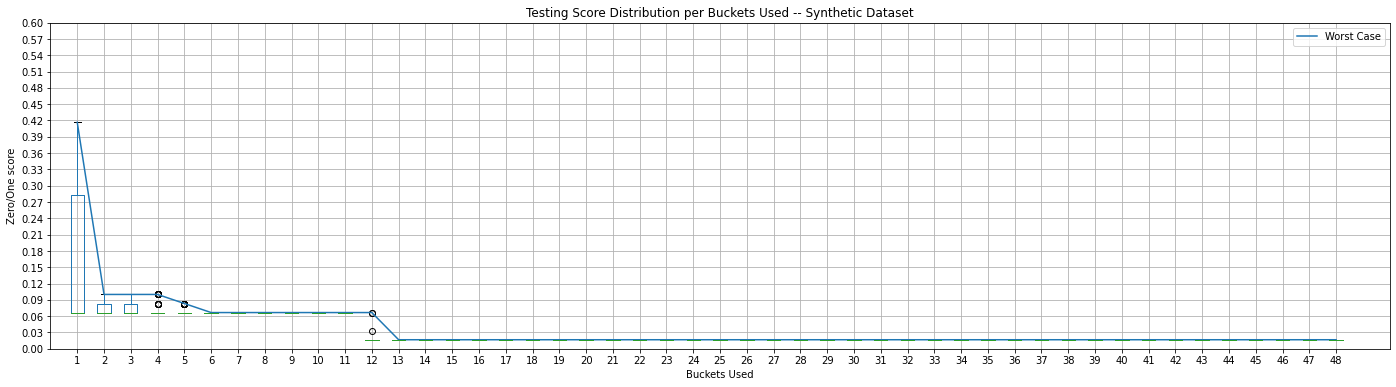

In [138]:
_, ax = plt.subplots()

exp_data = data['results']

pd.DataFrame(exp_data).boxplot(figsize=(15, 6), ax=ax)
pd.DataFrame(exp_data).max().plot(figsize=(24, 6), grid=True, ax=ax, legend=True, label='Worst Case')



ax.set_xlabel("Buckets Used")
ax.set_ylabel("Zero/One score")
ax.set_title(f"Testing Score Distribution per Buckets Used -- Synthetic Dataset")
ax.set_yticks(np.linspace(0, 0.6, 21))
ax.set_ylim(0, 0.6)
ax.set_xlim(0, 50)

In [139]:
pd.DataFrame({
    0.02: [8460],
    0.04: [6956],
    0.06: [3008],
    0.08: [1504],
    0.1 : [1128],
    0.2 : [114],
})

ValueError: If using all scalar values, you must pass an index

In [118]:
pd.DataFrame(data['results']).max()

1     0.825
2     0.550
3     0.200
4     0.050
5     0.050
6     0.050
7     0.050
8     0.050
9     0.050
10    0.050
11    0.050
12    0.050
13    0.050
14    0.050
15    0.050
16    0.050
17    0.050
18    0.050
19    0.050
20    0.050
21    0.050
22    0.050
23    0.025
24    0.050
25    0.050
26    0.050
27    0.050
28    0.050
29    0.050
30    0.050
31    0.050
32    0.050
33    0.050
34    0.050
35    0.050
36    0.050
37    0.050
38    0.050
39    0.050
40    0.050
41    0.050
42    0.050
43    0.050
44    0.050
45    0.050
46    0.050
47    0.050
48    0.050
dtype: float64

In [141]:
pd.DataFrame({
    'Number of Data Points': [1710, 1406, 646, 304, 228, 114],
    'Corrupted Instances'  : [190, 494, 1254, 1596, 1672, 1786],
    'Percentage'           : [0.1, 0.26, 0.66, 0.84, 0.88, 0.94]
}, index=[0.01, 0.02, 0.05, 0.08, 0.1, 0.2])

,Number of Data Points,Corrupted Instances,Percentage
0.01,1710,190,0.10
0.02,1406,494,0.26
0.05,646,1254,0.66
0.08,304,1596,0.84
0.10,228,1672,0.88
0.20,114,1786,0.94


# Dataset Creation Skin/NoSkin

In [1]:
from scipy.io import arff
import pandas as pd

data = arff.loadarff('./datasets/skinNoSkin.arff')
skin = pd.DataFrame(data[0])

In [3]:
skin.to_csv("./datasets/skinNoSkin.csv", index_label=False)

In [4]:
pd.read_csv('./datasets/skinNoSkin.csv')

,V1,V2,V3,Class
0,74.0,85.0,123.0,b'1'
1,73.0,84.0,122.0,b'1'
2,72.0,83.0,121.0,b'1'
3,70.0,81.0,119.0,b'1'
4,70.0,81.0,119.0,b'1'
...,...,...,...,...
245052,163.0,162.0,112.0,b'2'
245053,163.0,162.0,112.0,b'2'
245054,163.0,162.0,112.0,b'2'
245055,163.0,162.0,112.0,b'2'


In [5]:
skin['Class'] = skin.Class.astype(int)

In [6]:
skin

,V1,V2,V3,Class
0,74.0,85.0,123.0,1
1,73.0,84.0,122.0,1
2,72.0,83.0,121.0,1
3,70.0,81.0,119.0,1
4,70.0,81.0,119.0,1
...,...,...,...,...
245052,163.0,162.0,112.0,2
245053,163.0,162.0,112.0,2
245054,163.0,162.0,112.0,2
245055,163.0,162.0,112.0,2


In [7]:
skin.to_csv("./datasets/skinNoSkin.csv", index_label=False)

In [12]:
from sklearn import datasets

datasets.load_iris()

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  

In [13]:
datasets.load_iris()

{'data': array([[5.1, 3.5, 1.4, 0.2],
        [4.9, 3. , 1.4, 0.2],
        [4.7, 3.2, 1.3, 0.2],
        [4.6, 3.1, 1.5, 0.2],
        [5. , 3.6, 1.4, 0.2],
        [5.4, 3.9, 1.7, 0.4],
        [4.6, 3.4, 1.4, 0.3],
        [5. , 3.4, 1.5, 0.2],
        [4.4, 2.9, 1.4, 0.2],
        [4.9, 3.1, 1.5, 0.1],
        [5.4, 3.7, 1.5, 0.2],
        [4.8, 3.4, 1.6, 0.2],
        [4.8, 3. , 1.4, 0.1],
        [4.3, 3. , 1.1, 0.1],
        [5.8, 4. , 1.2, 0.2],
        [5.7, 4.4, 1.5, 0.4],
        [5.4, 3.9, 1.3, 0.4],
        [5.1, 3.5, 1.4, 0.3],
        [5.7, 3.8, 1.7, 0.3],
        [5.1, 3.8, 1.5, 0.3],
        [5.4, 3.4, 1.7, 0.2],
        [5.1, 3.7, 1.5, 0.4],
        [4.6, 3.6, 1. , 0.2],
        [5.1, 3.3, 1.7, 0.5],
        [4.8, 3.4, 1.9, 0.2],
        [5. , 3. , 1.6, 0.2],
        [5. , 3.4, 1.6, 0.4],
        [5.2, 3.5, 1.5, 0.2],
        [5.2, 3.4, 1.4, 0.2],
        [4.7, 3.2, 1.6, 0.2],
        [4.8, 3.1, 1.6, 0.2],
        [5.4, 3.4, 1.5, 0.4],
        [5.2, 4.1, 1.5, 0.1],
  